**Installing and Importing Modules**

**Score:** 10/10. You got an extra point for turning in early, but you got a point off because your code didn't have a test.

In [1]:
!pip install -q control
!pip install -q tellurium

     |████████████████████████████████| 357 kB 7.4 MB/s 
     |████████████████████████████████| 121 kB 6.3 MB/s 
     |████████████████████████████████| 3.3 MB 12.9 MB/s 
     |████████████████████████████████| 54.8 MB 120 kB/s 
     |████████████████████████████████| 5.0 MB 40.9 MB/s 
     |████████████████████████████████| 38.1 MB 1.1 MB/s 
     |████████████████████████████████| 5.6 MB 67.4 MB/s 
     |████████████████████████████████| 2.1 MB 41.7 MB/s 
     |████████████████████████████████| 3.2 MB 35.7 MB/s 
     |████████████████████████████████| 6.9 MB 42.6 MB/s 
     |████████████████████████████████| 2.6 MB 45.9 MB/s 
     |████████████████████████████████| 36.7 MB 1.2 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [2]:
import control
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tellurium as te

**Building the Accuracy Function**

In [3]:
"""
Acceptable Species Name Inputs: "S2" and "S3"
"""

def analyze(operating_time, species):
  ## User-defined variables ##
  OP_time = operating_time  # setting the operating time
  input_species = species  # setting the species chosen

  ## Tellurium simulation ##
  NONLINEAR_MDL = """
  J1: S1 -> S2; k1*S1
  J2: S1 + S2 -> 3 S3; k2*S1*S2
  J3: S3 -> ; k3*S3
  J4: 2 S1 + S3 -> S2; k4*S1*S1*S3

  k1 = 2
  k2 = 1.5
  k3 = 1
  k4 = 0.5
  S1 = 10
  S2 = 0
  S3 = 0
  """

  NONLINEAR_RR = te.loada(NONLINEAR_MDL)  # load model into libRoadRunner
  NONLINEAR_DATA = NONLINEAR_RR.simulate()  # simulate the model
  simulation_points = len(NONLINEAR_DATA)  # Length of each species column vector from tellurium simulatiln
  # print('How many points are collected for each species in the simulation:',simulation_points)
  plt.figure()
  plt.plot(NONLINEAR_DATA[:,0],NONLINEAR_DATA[:,1], label='S1')
  plt.plot(NONLINEAR_DATA[:,0],NONLINEAR_DATA[:,2], label='S2')
  plt.plot(NONLINEAR_DATA[:,0],NONLINEAR_DATA[:,3], label='S3')
  plt.title('Tellurium Simulation')
  plt.ylabel('Concentration')
  plt.xlabel('Time')
  plt.legend()
 
  ## Function to run the simulation  ##
  def simulation_run(sim_roadrunner,time):
    sim_roadrunner.reset()
    if time > 0:  # otherwise reset simulation will defer to initial values 
      sim_roadrunner.simulate(0,time)
    return sim_roadrunner  
  
  ## Function to create a dictionary of species and values ##
  def values(sim_roadrunner):
    species_list = sim_roadrunner.getFloatingSpeciesIds()  # returns string of species in simulation
    species_dct = {species: sim_roadrunner[species] for species in species_list}  # extract dictionary of species and values from simulation
    return species_dct
  
  ## Concentrations at time 0 ##
  initial_roadrunner = simulation_run(NONLINEAR_RR, 0)
  initial_dct = values(initial_roadrunner)  # a dictionary of species and initial values 
  initial_values = list(initial_dct.values())  # extracts values of simulation at time 0 from dictionary
  initial_values = np.array(initial_values)  # changing a list to an array

  ## Calculating the Jacobian ##
  roadrunner = simulation_run(NONLINEAR_RR, OP_time) 
  dct = values(roadrunner)
  A = roadrunner.getFullJacobian()  # calculates the Jacobian at the operating point to help create the state space model
  B = np.array([1,0,0])  # input array: assuming S1 is always the input
  B = np.reshape(B,(3,1))
  if input_species == 'S2':
    C = np.array([0,1,0])  # output array
  else:
    C = np.array([0,0,1])  # output array
  C = np.reshape(C,(1,3))
  D = 0 # no feedback control assumed in this model

  ## Creating the State Space Model for Linearization ##
  state_space = control.StateSpace(A,B,C,D)  # creates a statespace model

  ## Linearization using a First-Order Taylor Series ##
  sim_times = [0.1*v for v in range(simulation_points)]
  linearization_results = control.forced_response(state_space, sim_times, X0=initial_values)
  linear_time = linearization_results.t  # extracts time values from linearization
  linear_values = linearization_results.y  # extracts concentration values from linearization
  
  ## Representing the Results ## 
  plt.figure()
  plt.plot(linear_time.flatten(), linear_values.flatten(), label='Linearization')
  if input_species == 'S2':
    plt.plot(NONLINEAR_DATA[:,0],NONLINEAR_DATA[:,2], label='Tellurium')
  else:
    plt.plot(NONLINEAR_DATA[:,0],NONLINEAR_DATA[:,3], label='Tellurium')
  plt.ylabel('Concentration')
  plt.xlabel('Time')
  plt.title('Species={0}, Operating Time={1}'.format(input_species,OP_time))
  plt.legend()
  plt.ylim([-5, 15])
  return linearization_results

**Accuracy Function Tests**

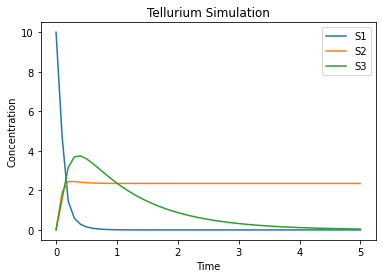

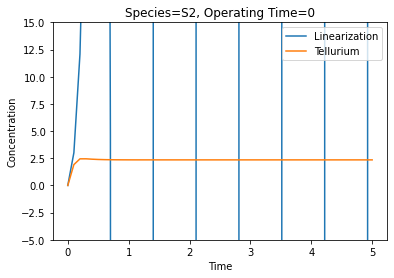

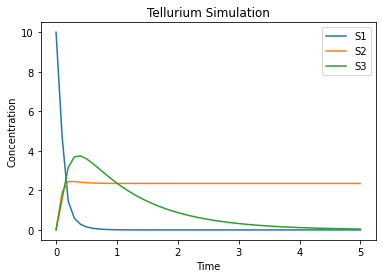

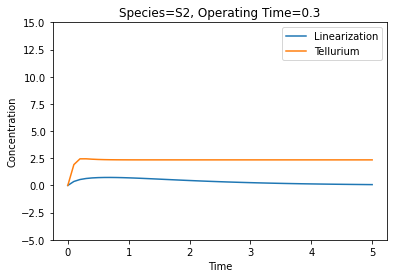

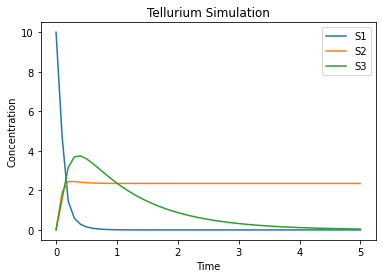

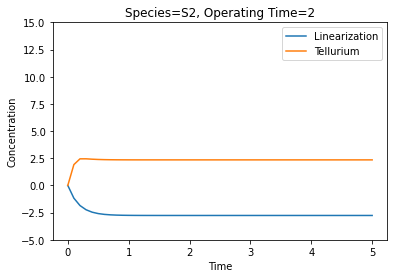

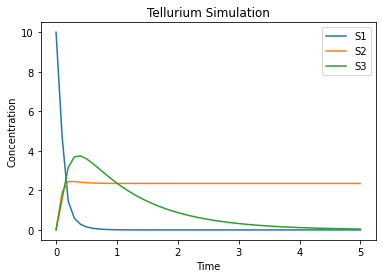

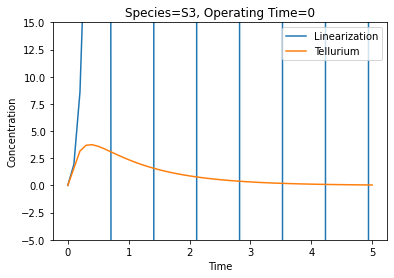

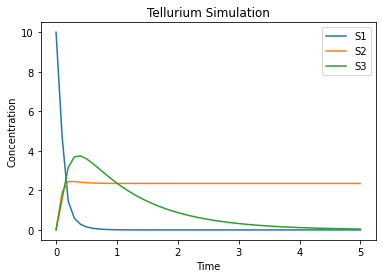

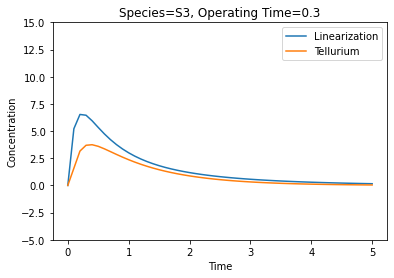

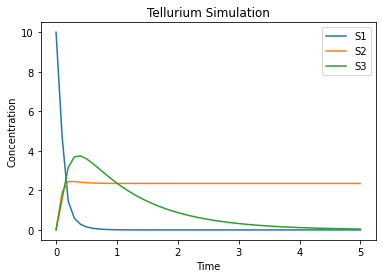

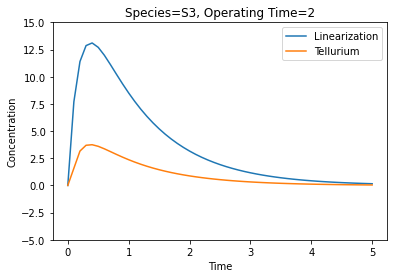

In [4]:
## Analyze S2 and S3 with operating times = 0, 0.3, 2  ##

# S2, operating time = 0
result = analyze(operating_time=0, species='S2')

# S2, operating time = 0.3
result = analyze(operating_time=0.3, species='S2')

# S2, operating time = 2
result = analyze(operating_time=2, species='S2')

# S3, operating time = 0
result = analyze(operating_time=0, species='S3')

# S3, operating time = 0.3
result = analyze(operating_time=0.3, species='S3')

# S3, operating time = 2
result = analyze(operating_time=2, species='S3')

**Where are the largest discrepancies between the original simulation and the linearized models? Why?**

To linearize around a single operating point, I used a first order Taylor Series Expansion centered at that operating point. For this model to be more accurate, it would be necessary to linearize at many different operating points along the curve. 

Below I will discuss the largest discrepencies between the original simulation and the linearized model.

A Taylor Series approximation is the function that is the sum of derivatives at the operating point. At time=0, both species S2 and S3 are initially produced very quickly and therefore calculating the derivatives of a near vertical line is infinite. As such, the model is only accurate very close to the operating line and will produce vertical tangent lines for each point away from the operating line. 

At an operating time = 2 for species S2, the linearized model is transposed across the x-axis. We can see from the tellurium simulation that species S2 reaches a steady state after a very short period of time. As the linearized model will be the most accurate around the operating point, the linearized model will reach a steady state at the same time as the tellurium model. As the tangent to S2 at the operating time=2 is 0 (Jacobian is computing the derivatives as discussed previously), the model is accurate for all points once species S2 has reached steady state, but highly innacurate before then producing the negative output. 